# 05 Error Metrics

_[Estimated execution time: 15 min]_

The toolkit allows to evaluate standard error metrics automatically. This notebook will continue the air quality data set used in the previous tutorial [04 Model Training](https://github.com/GAMES-UChile/mogptk/blob/master/examples/04_Model_Training.ipynb).

In [1]:
import mogptk
import torch
import numpy as np
import pandas as pd

torch.manual_seed(1);

# Air Quality MOGP

For this tutorial we will use the air quality dataset. The data set contains hourly averaged responses from an array of five metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located in the field in a significantly polluted area in an Italian city. Data were recorded for one year from March 2004 representing the longest freely available recordings of a deployed air quality chemical sensor device.

We will only use five columns: CO(GT), NMHC(GT), C6H6(GT), NOx(GT), NO2(GT). For more information on data loading check out the tutorial [01 Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb). For more information on data handling check out the tutorial [02 Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb).

For each sensor the minimum value is -200, which is also the default value when there is an error in the measurements. We will ignore them by converting them to `NaN`.

In [2]:
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# Replace missing values with NaN
df.replace(-200.0, np.nan, inplace=True)

# First two columns are date and time
# We convert it to a single column with datetime format
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# Define an initial date to compare all other to it
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# Get elapsed hours
df['Time'] = (df['Date'] - ini_date) / pd.Timedelta(hours=1)

# Use only the first eight days of data
df2 = df[df['Date'] < pd.Timestamp('2004-03-19 00:00:00.0')]

Remove aditional data to simulate sensor failure. In this case for each channel we will first remove 50% of the observations and then remove complete sectors in order to get reconstructions from the other channels through learned cross correlations.

We will also use data transformation as defined in the data preparation and transformation tutorial [02 Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb) where each channel is normalized so it has zero mean and unit variance.

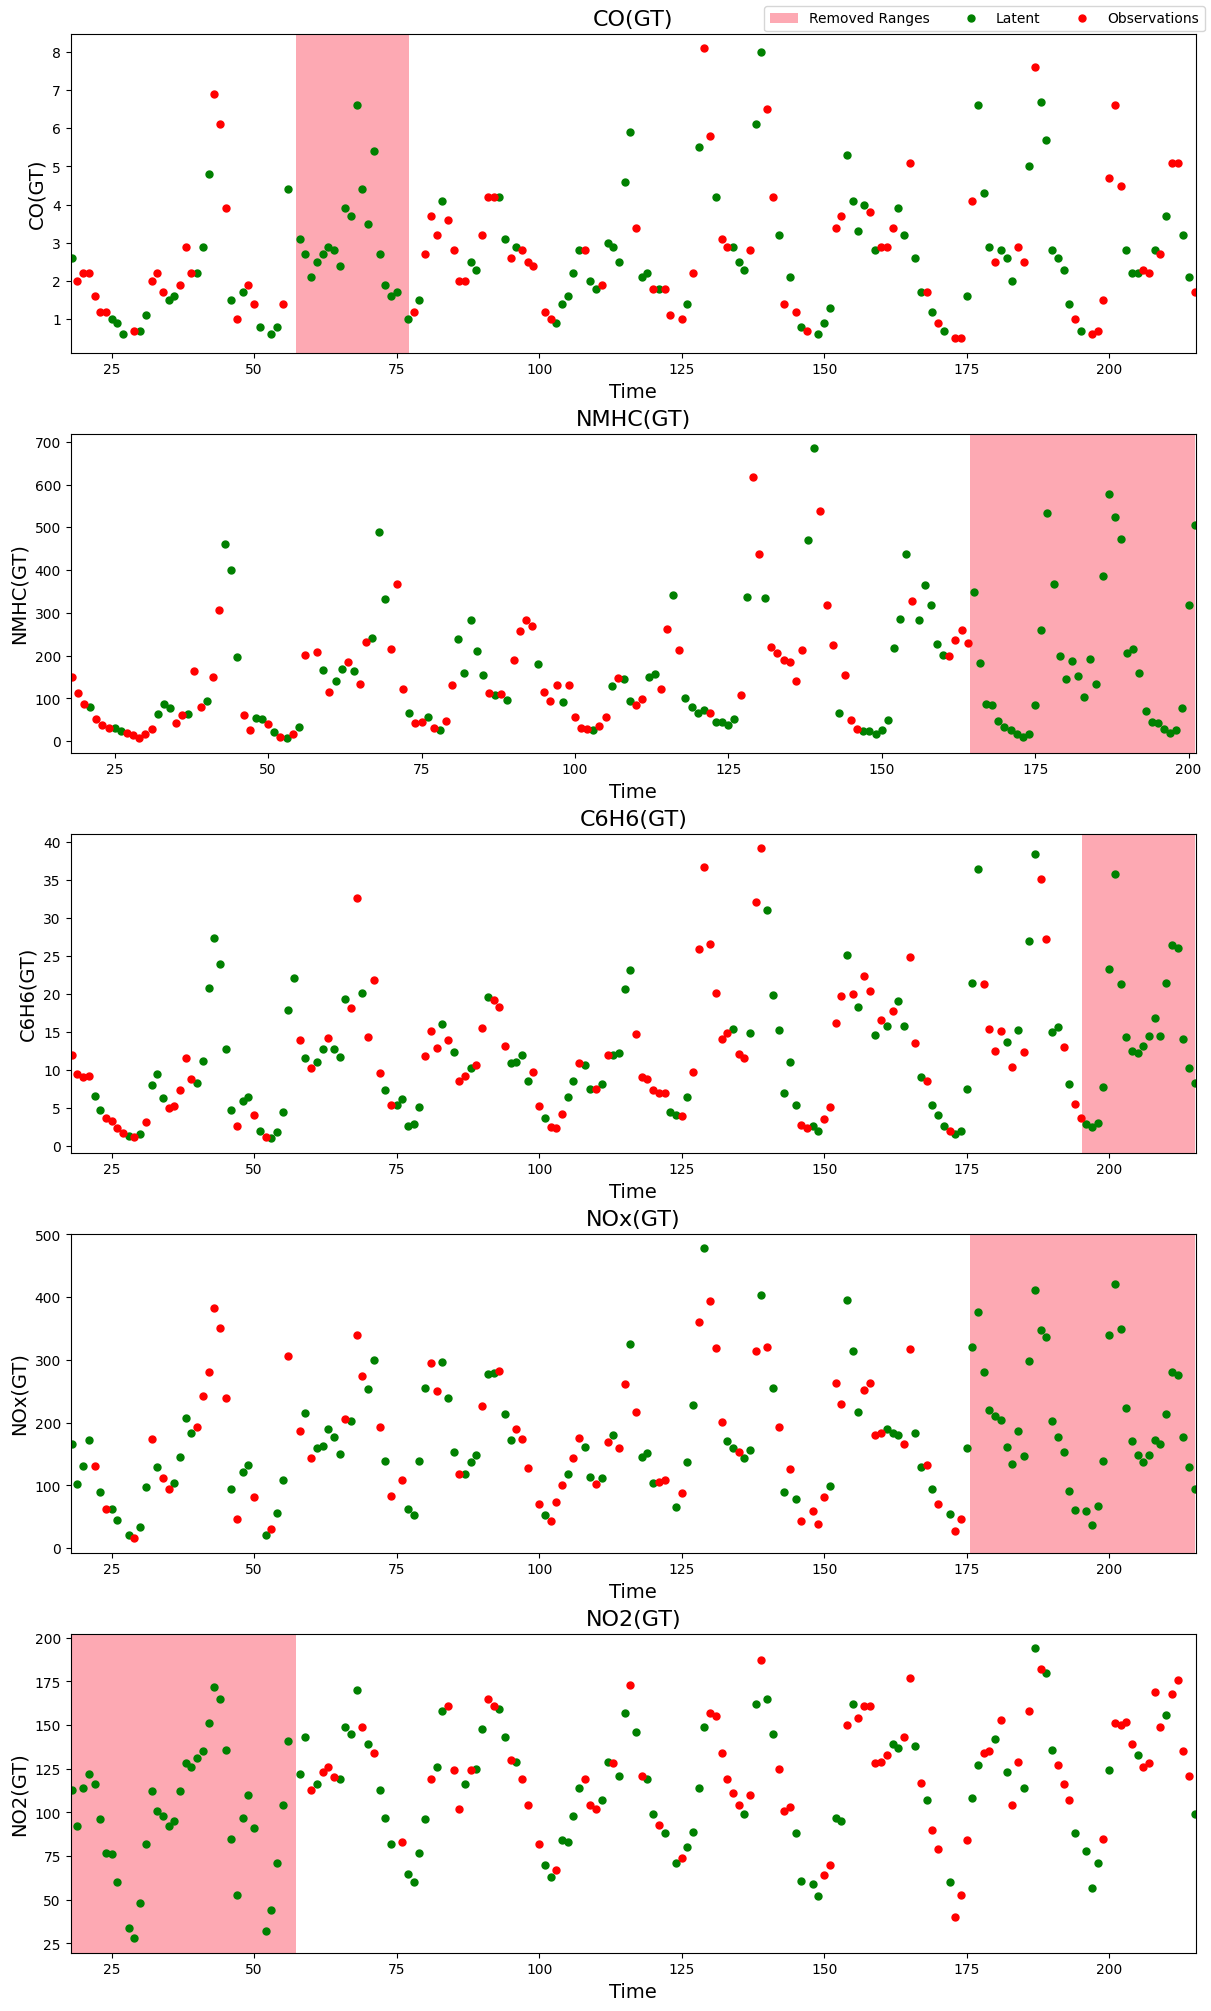

In [3]:
cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
dataset = mogptk.LoadDataFrame(df2, x_col='Time', y_col=cols)

for channel in dataset:
    channel.remove_randomly(pct=0.5)

# drop relative ranges to simulate sensor failure
dataset[0].remove_relative_range(0.2, 0.3)
dataset[1].remove_relative_range(0.8, 1.0)
dataset[2].remove_relative_range(0.9, 1.0)
dataset[3].remove_relative_range(0.8, 1.0)
dataset[4].remove_relative_range(0.0, 0.2)

for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))
    channel.transform(mogptk.TransformStandard())
dataset.plot();

# Models

We will use one of each of the models in the toolkit, starting with independent Gaussian processes with an [SM](https://games-uchile.github.io/mogptk/sm.html) kernel.

In [4]:
method = 'Adam'
iters = 1000
lr = 0.015

## Independent channels with spectral mixture kernels

For each channel we will use four mixtures.

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: IndependentMultiOutputKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 5
‣ Parameters: 65
‣ Training points: 401
‣ Iterations: 1000
     0/1000   0:00:01  loss=     493.812  error=     33.5505 (warmup)
    30/1000   0:00:10  loss=     482.051  error=     34.6115
   330/1000   0:00:20  loss=     417.233  error=     33.6955
   636/1000   0:00:30  loss=     400.423  error=     32.9908
   951/1000   0:00:40  loss=     395.632  error=     32.8146
  1000/1000   0:00:41  loss=     395.184  error=     32.7584
Optimization finished in 41.631 seconds


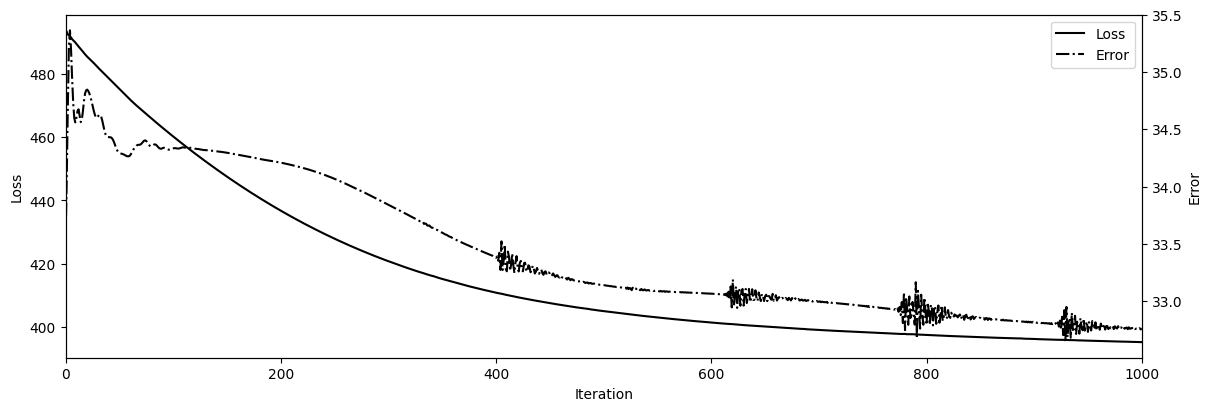

In [5]:
sm = mogptk.SM(dataset, Q=4)
sm.init_parameters('BNSE')
sm.train(method=method, lr=lr, iters=iters, verbose=True, error='MAE', plot=True);

### Evaluating errors

Using the [`mogptk.error`](https://games-uchile.github.io/mogptk/errors.html#mogptk.errors.error) function given a test input and output it calculates:

* Mean absolute error (MAE)
* Mean absolute percentage error (MAPE)
* Root mean squared error (RMSE)

If only the raw values $y_{true} - y_{pred}$ are desired, the flag `simple` must be passed.

Multiple models for the same test set (X, Y) can be passed at once, the result will be a list with one element for each model passed, where each element is another list of length equal to the number or channels where each element is the error for said model and channel. This enables to obtain errors for multiple models for the same test set where each channel can have different numbers of test points.

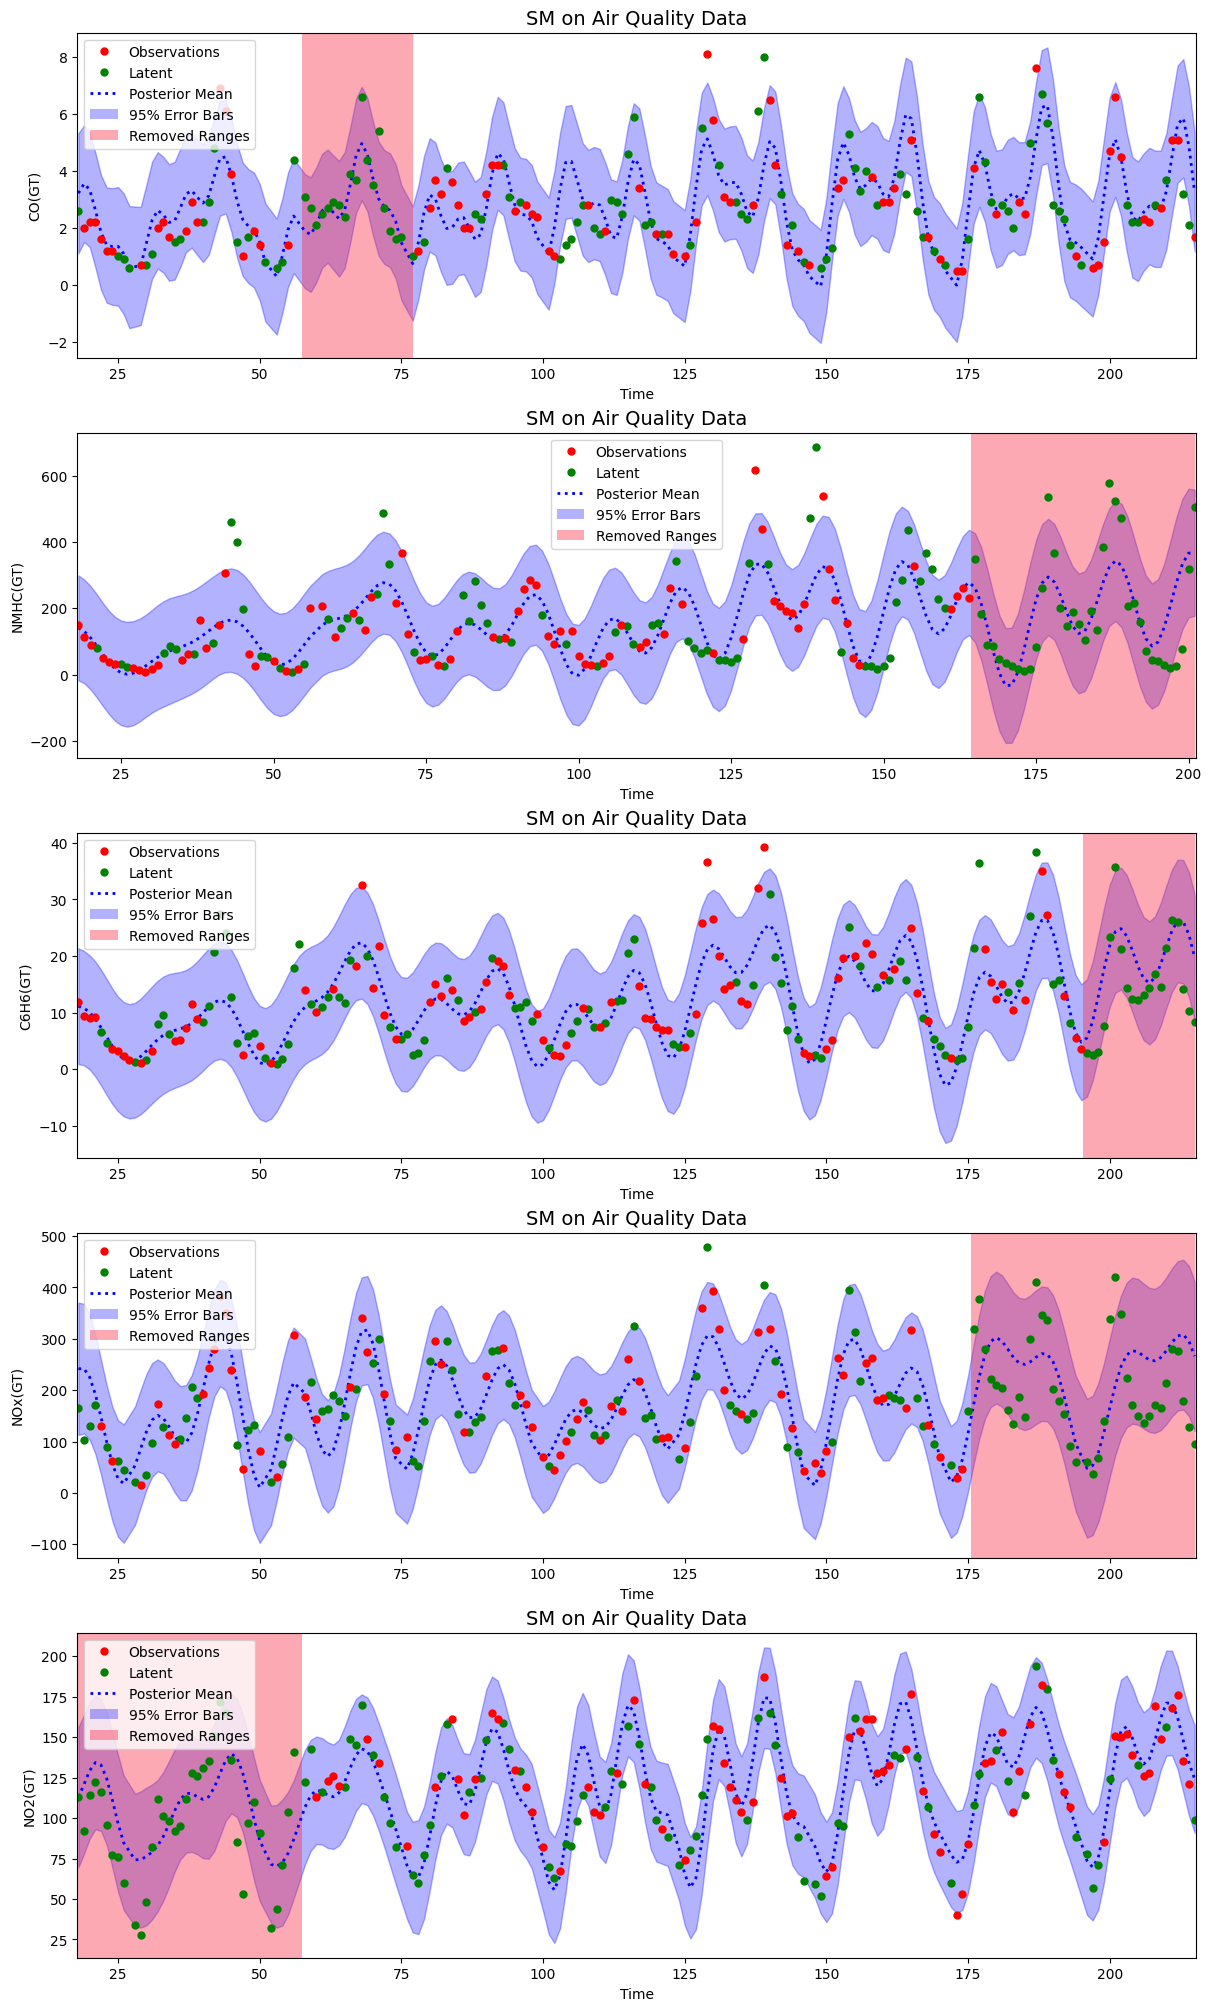

In [6]:
sm.plot_prediction(title='SM on Air Quality Data');

In [7]:
mogptk.error(sm, disp=True, per_channel=False);

MAE       MAPE       RMSE
Name                                 
SM    32.758392  51.100423  60.292392

## Multi Output Spectral Mixture (MOSM)

Next we use the multi output spectral mixture kernel (Parra et al, 2016).

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 5
‣ Parameters: 105
‣ Training points: 401
‣ Iterations: 1000
     0/1000   0:00:04  loss=     465.023  error=     31.6777 (warmup)
     2/1000   0:00:20  loss=     466.379  error=     32.2202
     3/1000   0:00:20  loss=     464.399  error=     31.9518
   122/1000   0:00:30  loss=     418.562  error=      29.907
   251/1000   0:00:40  loss=      391.92  error=       30.59
   374/1000   0:00:50  loss=     373.975  error=      30.546
   504/1000   0:01:00  loss=      366.26  error=     30.8178
   629/1000   0:01:10  loss=     363.238  error=     30.9285
   751/1000   0:01:20  loss=     362.178  error=     31.0244
   881/1000   0:01:30  loss=      361.64  error=     31.1205
  1000/1000   0:01:39  loss=     361.385  error=     31.2423
Optimization finished in 1 minute 39 seconds


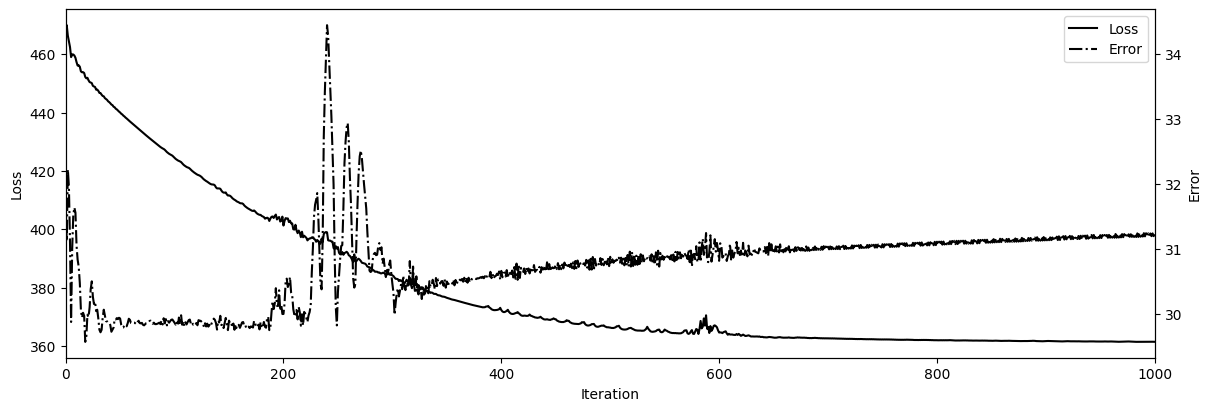

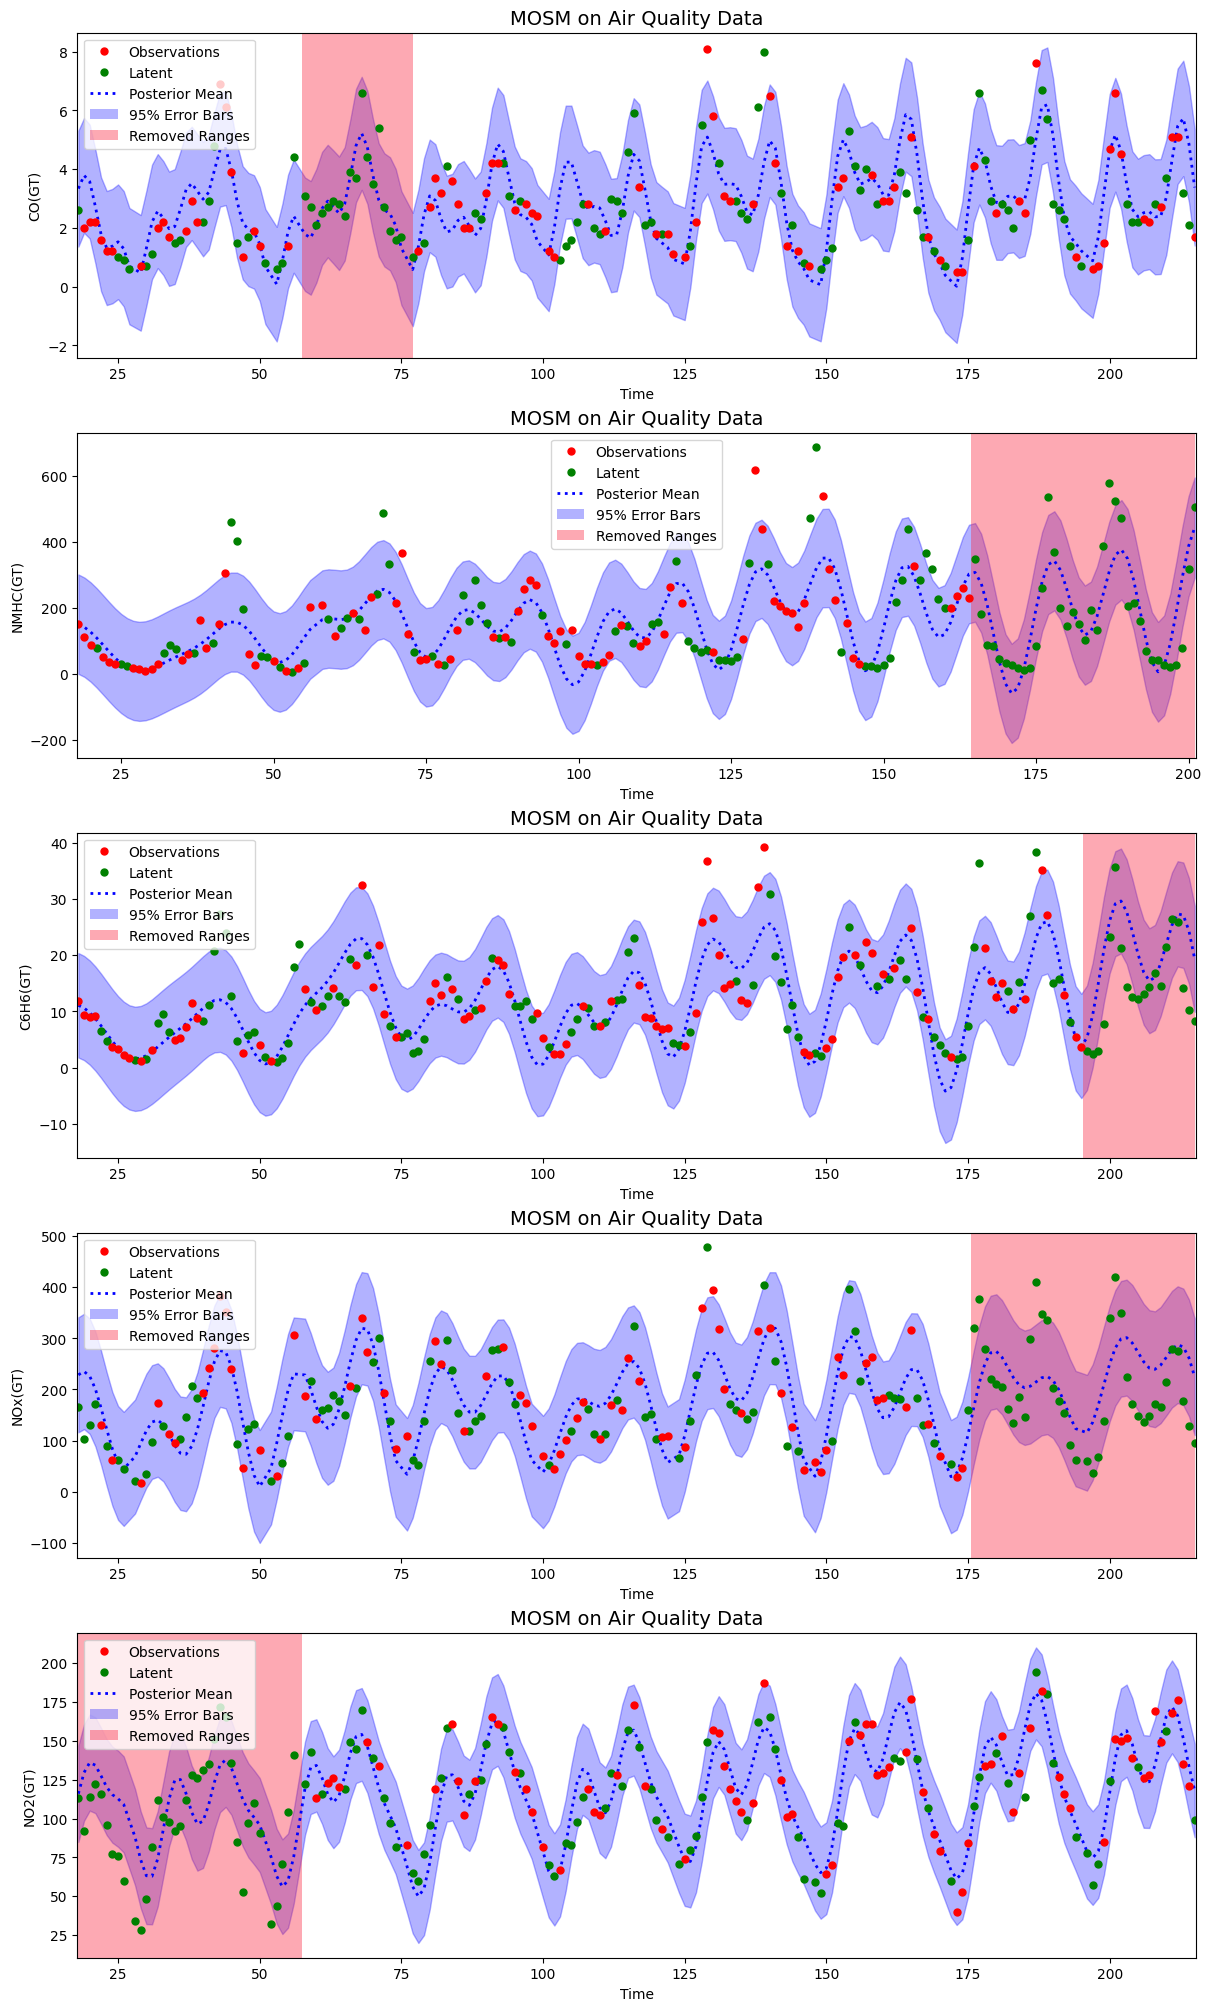

In [8]:
mosm = mogptk.MOSM(dataset, Q=4)
mosm.init_parameters('BNSE')
mosm.train(method=method, lr=lr, iters=iters, verbose=True, error='MAE', plot=True)
mosm.plot_prediction(title='MOSM on Air Quality Data');

## Cross Spectral Mixture (CSM)

Then we use the cross spectral mixture kernel (Ulrich et al, 2015).

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MixtureKernel.CrossSpectralKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 5
‣ Parameters: 53
‣ Training points: 401
‣ Iterations: 1000
     0/1000   0:00:09  loss=     458.857  error=     28.2007 (warmup)
     1/1000   0:00:10  loss=     460.084  error=     30.3136 (warmup)
     2/1000   0:00:59  loss=     454.891  error=     29.0431
     3/1000   0:00:59  loss=     454.519  error=     28.7162
     4/1000   0:00:59  loss=     455.341  error=     28.9863
     5/1000   0:01:00  loss=     454.292  error=     29.0775
     6/1000   0:01:00  loss=      452.94  error=     29.1527
    66/1000   0:01:10  loss=     431.544  error=       28.33
   127/1000   0:01:20  loss=      414.01  error=     27.9179
   192/1000   0:01:30  loss=     399.045  error=     27.5828
   255/1000   0:01:40  loss=     388.186  error=     27.3395
   318/1000   0:01:50  loss=     380.639  error=     27.1727
   380/1000   0:02:00  loss=     375.885  error=

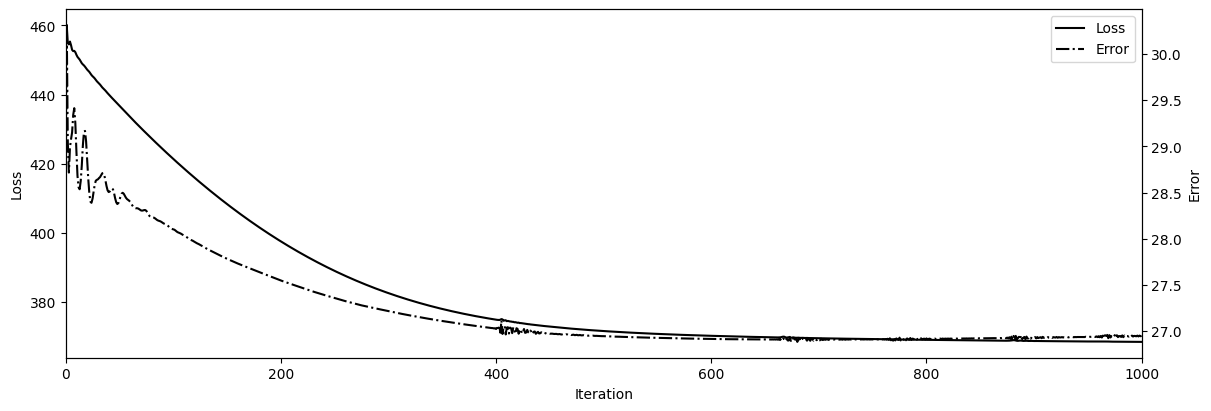

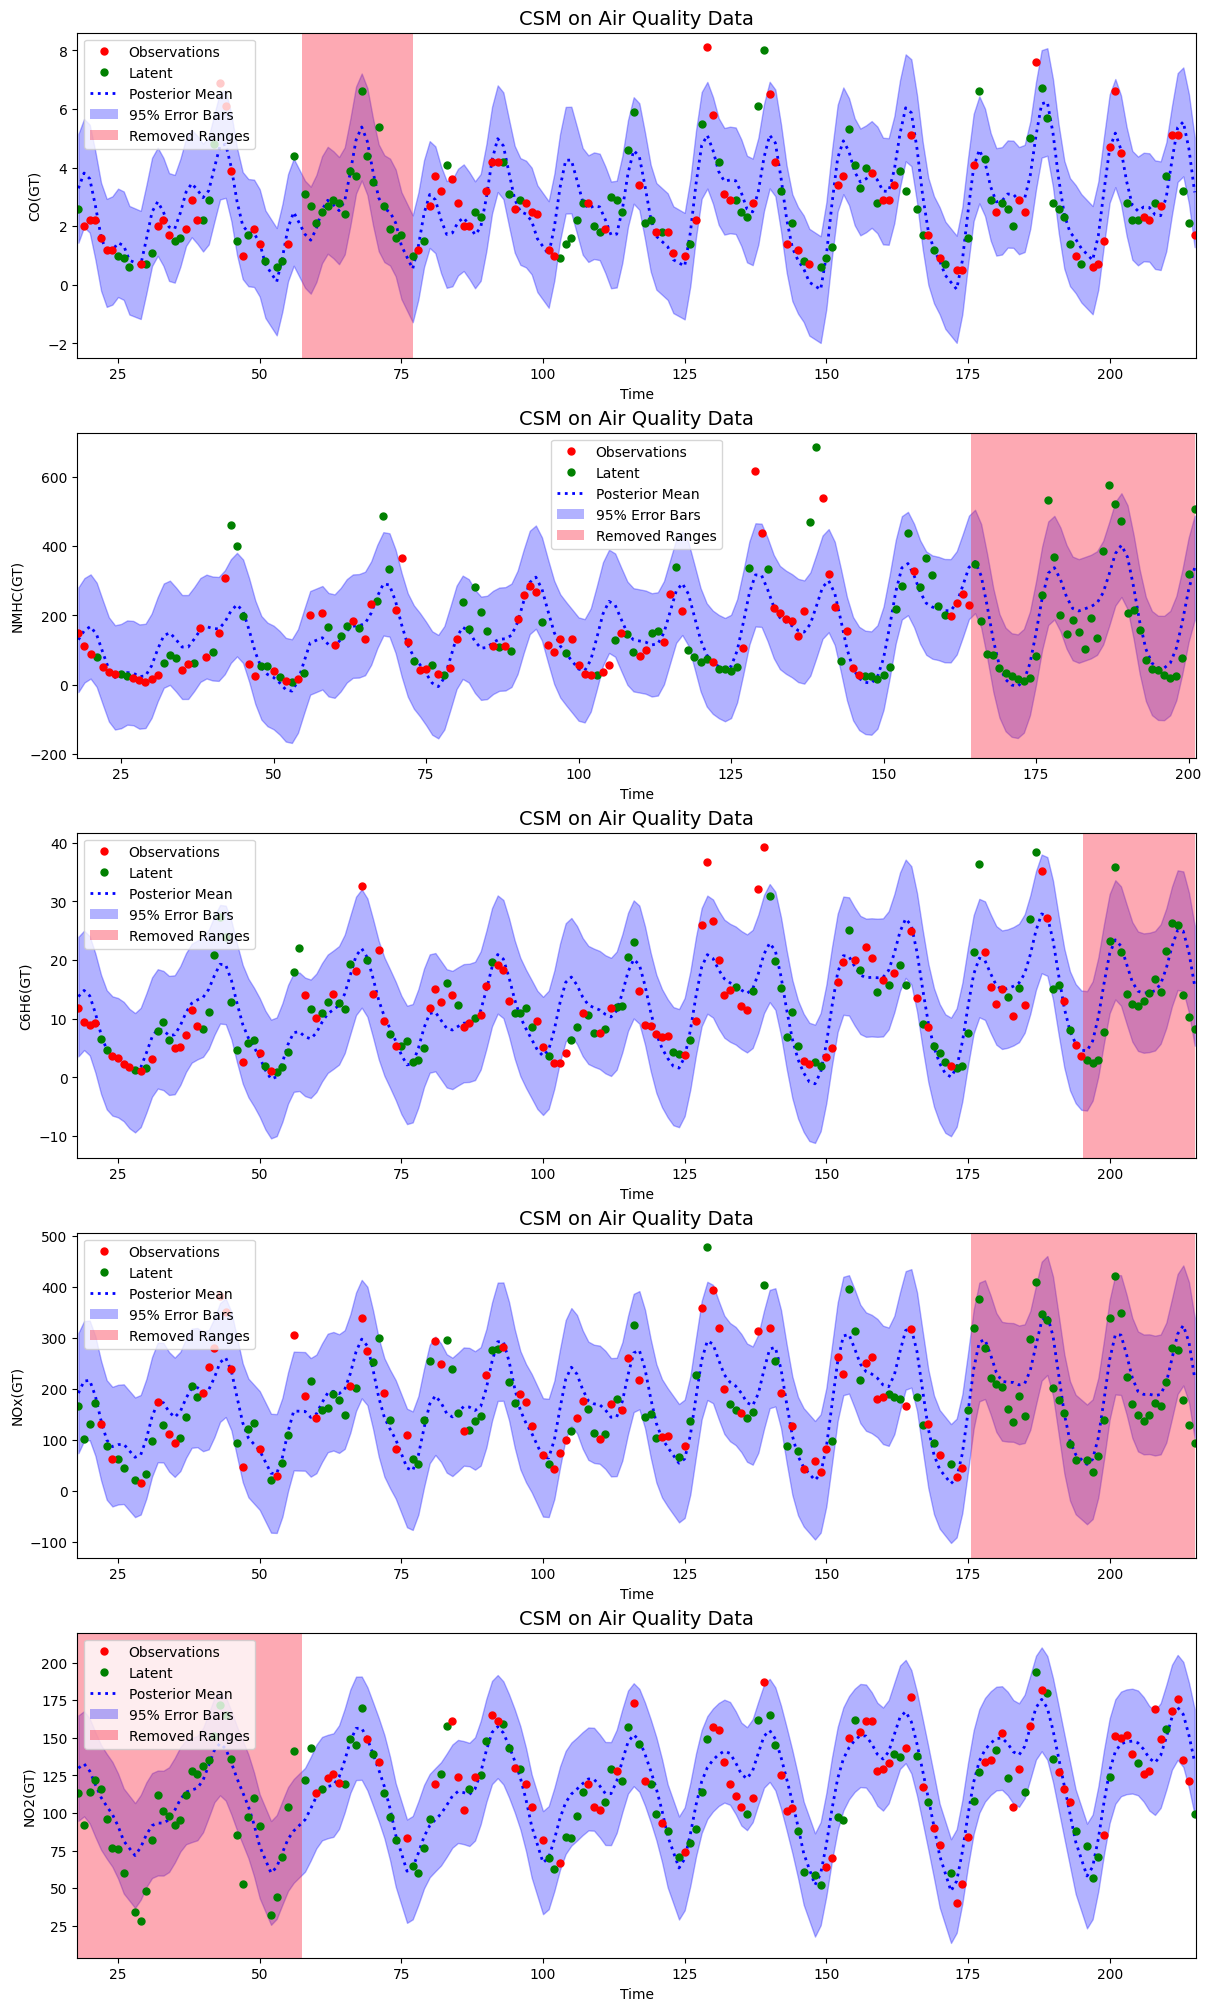

In [9]:
csm = mogptk.CSM(dataset, Q=4)
csm.init_parameters()
csm.train(method=method, lr=lr, iters=iters, verbose=True, error='MAE', plot=True)
csm.plot_prediction(title='CSM on Air Quality Data');

## Spectral Mixture - Linear Model of Corregionalization (SM-LMC)

Lastly we fit the spectral mixture linear model of corregionalization (Wilson, 2014).

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: LinearModelOfCoregionalizationKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 5
‣ Parameters: 33
‣ Training points: 401
‣ Iterations: 1000
     0/1000   0:00:06  loss=     462.438  error=     27.8478 (warmup)
     2/1000   0:00:45  loss=     461.582  error=     27.9806
     3/1000   0:00:45  loss=     461.076  error=     27.8748
     4/1000   0:00:45  loss=     460.679  error=     27.8053
     5/1000   0:00:45  loss=     460.307  error=     27.7862
    45/1000   0:00:50  loss=     444.873  error=      27.584
   139/1000   0:01:00  loss=     415.802  error=     27.2393
   232/1000   0:01:10  loss=     397.499  error=     27.1011
   325/1000   0:01:20  loss=      387.23  error=     27.0715
   418/1000   0:01:30  loss=     382.125  error=     27.0886
   510/1000   0:01:40  loss=     379.879  error=     27.0907
   617/1000   0:01:50  loss=     378.659  error=     27.0857
   721/1000   0:02:00  loss=     378.005  error=     2

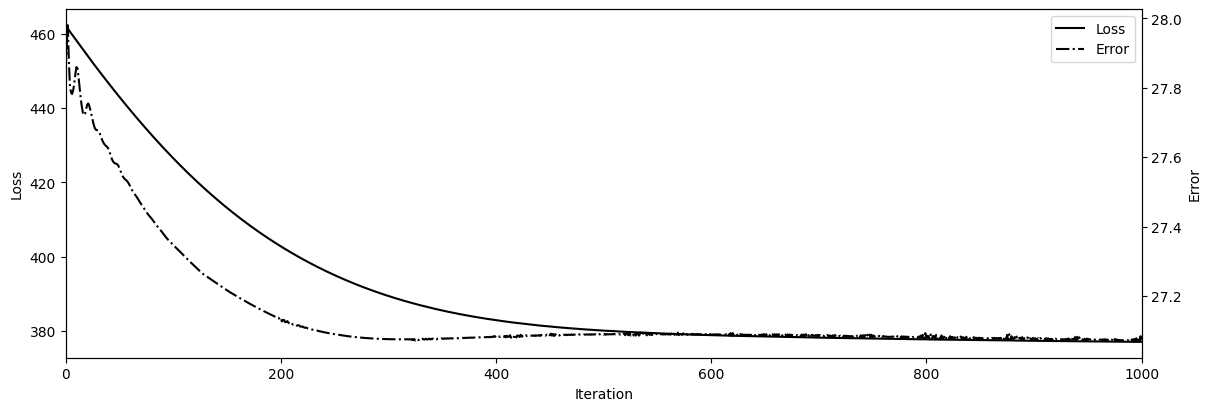

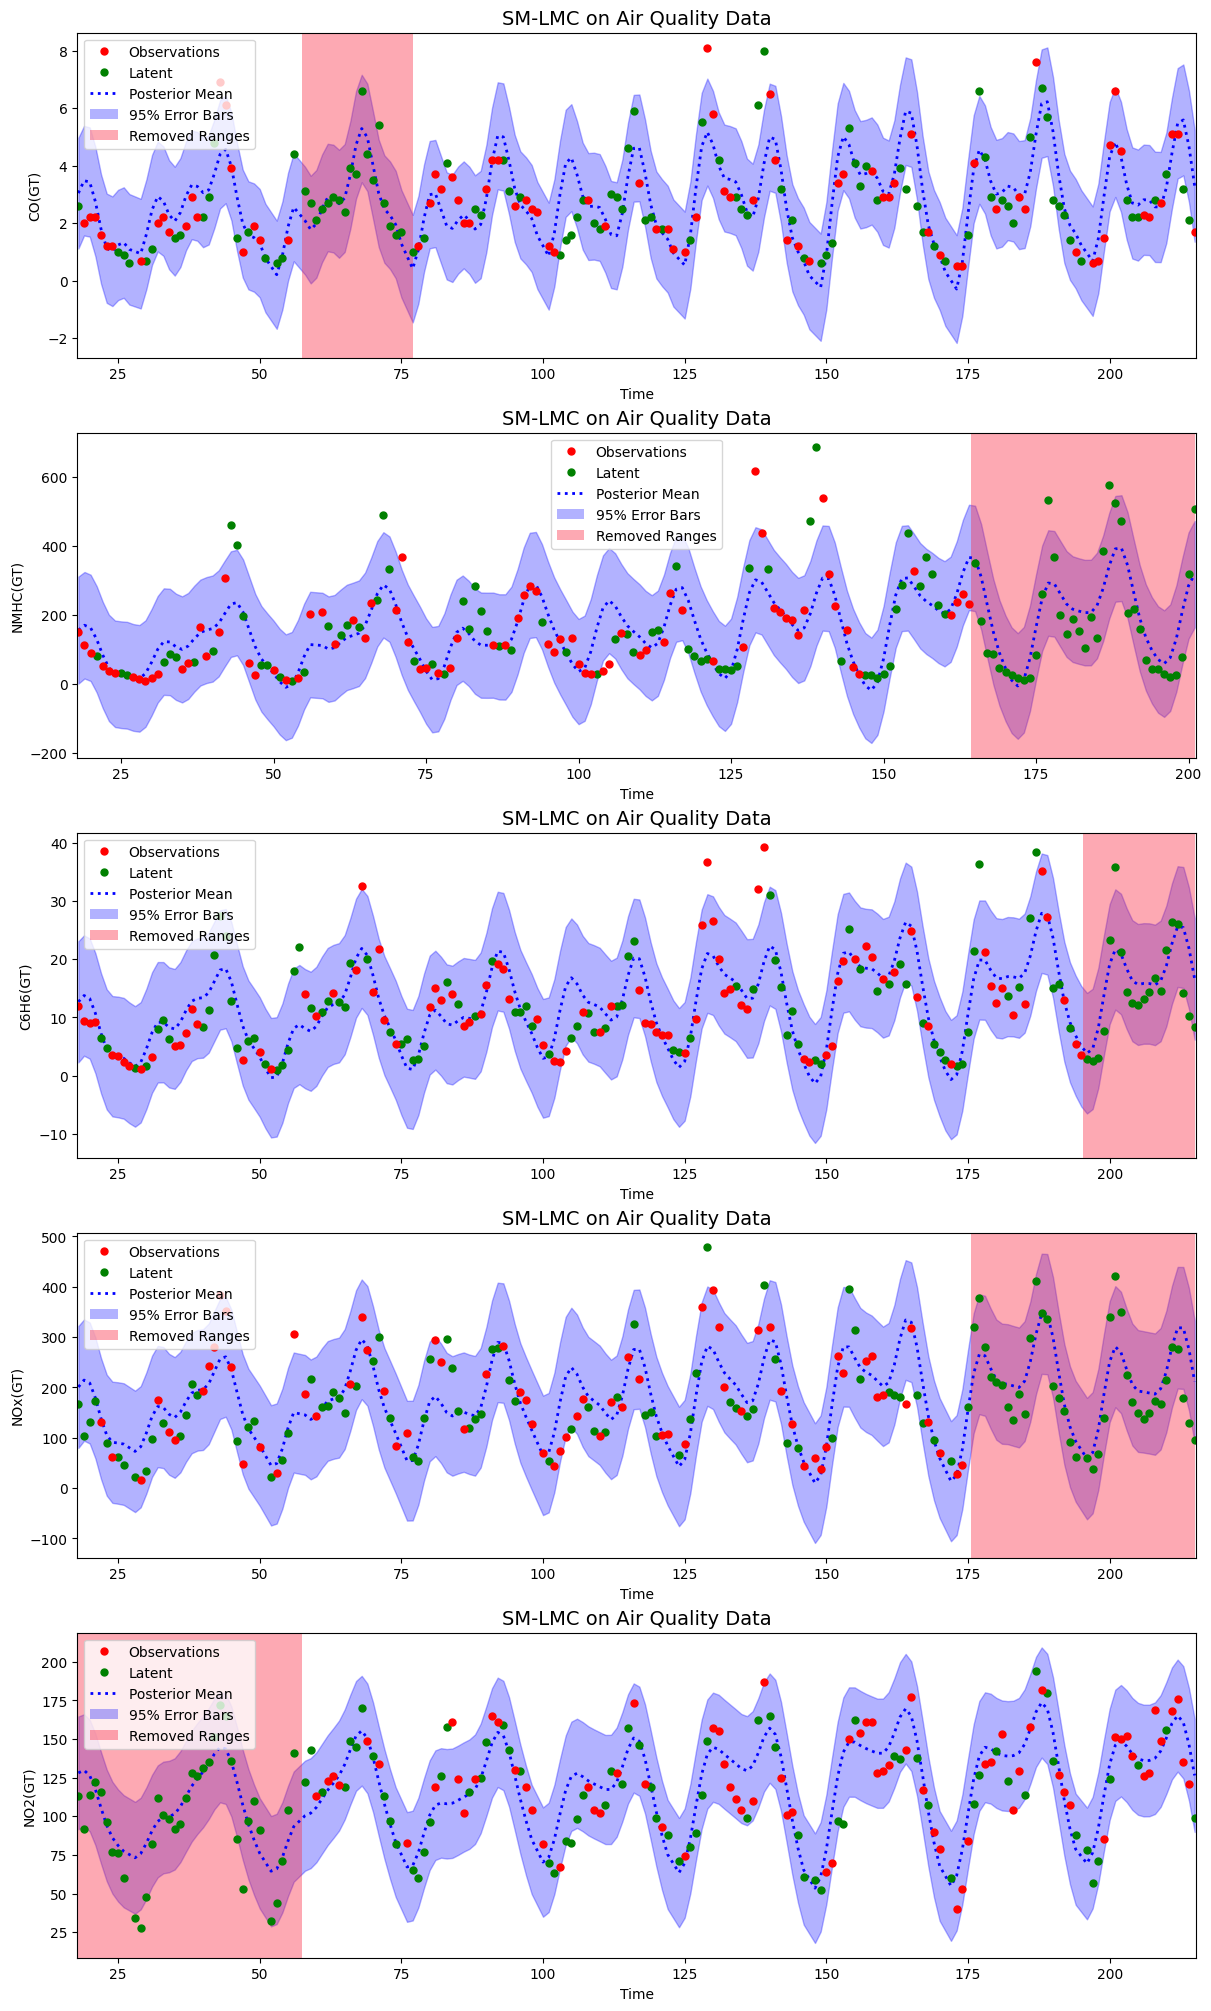

In [10]:
smlmc = mogptk.SM_LMC(dataset, Q=4)
smlmc.init_parameters()
smlmc.train(method=method, lr=lr, iters=iters, verbose=True, error='MAE', plot=True)
smlmc.plot_prediction(title='SM-LMC on Air Quality Data');

## Convolutional Gaussian (CONV)

/home/taco/src/mogptk/mogptk/gpr/parameter.py:219: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201336/work/torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(value, device=config.device, dtype=config.dtype)


Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MixtureKernel.GaussianConvolutionProcessKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 5
‣ Parameters: 49
‣ Training points: 401
‣ Iterations: 1000
     0/1000   0:00:06  loss=     596.674  error=     23.5805 (warmup)
     2/1000   0:00:33  loss=     595.608  error=     23.5612
     3/1000   0:00:34  loss=     595.075  error=     23.5515
     4/1000   0:00:34  loss=     594.543  error=     23.5418
    36/1000   0:00:40  loss=     577.754  error=     23.2108
    90/1000   0:00:50  loss=     550.194  error=     22.6027
   146/1000   0:01:00  loss=     521.932  error=     21.8585
   200/1000   0:01:10  loss=     494.961  error=     20.9856
   254/1000   0:01:20  loss=     468.328  error=     20.0551
   308/1000   0:01:30  loss=     442.135  error=     19.1864
   366/1000   0:01:40  loss=     414.681  error=     18.3462
   422/1000   0:01:50  loss=     389.117  error=     17.6593
   479/1000   0:02:00  loss=     364.429  er

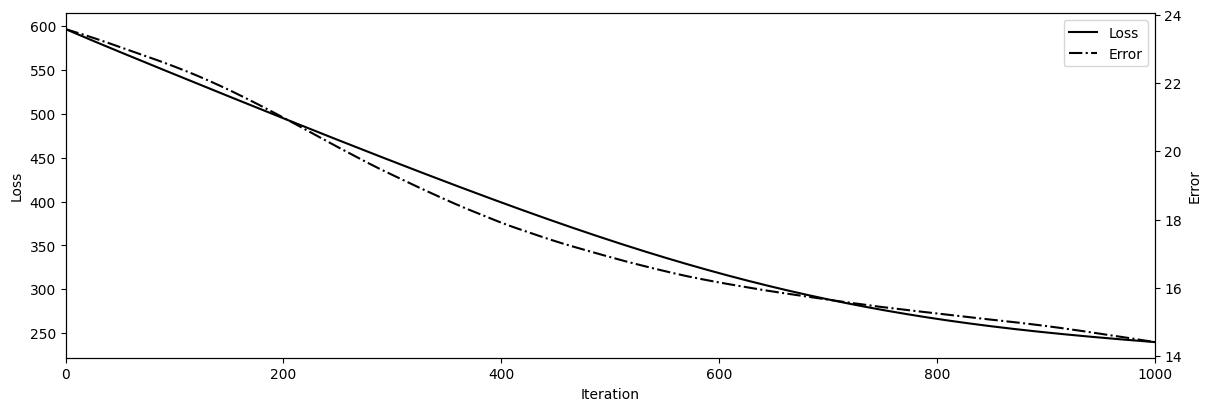

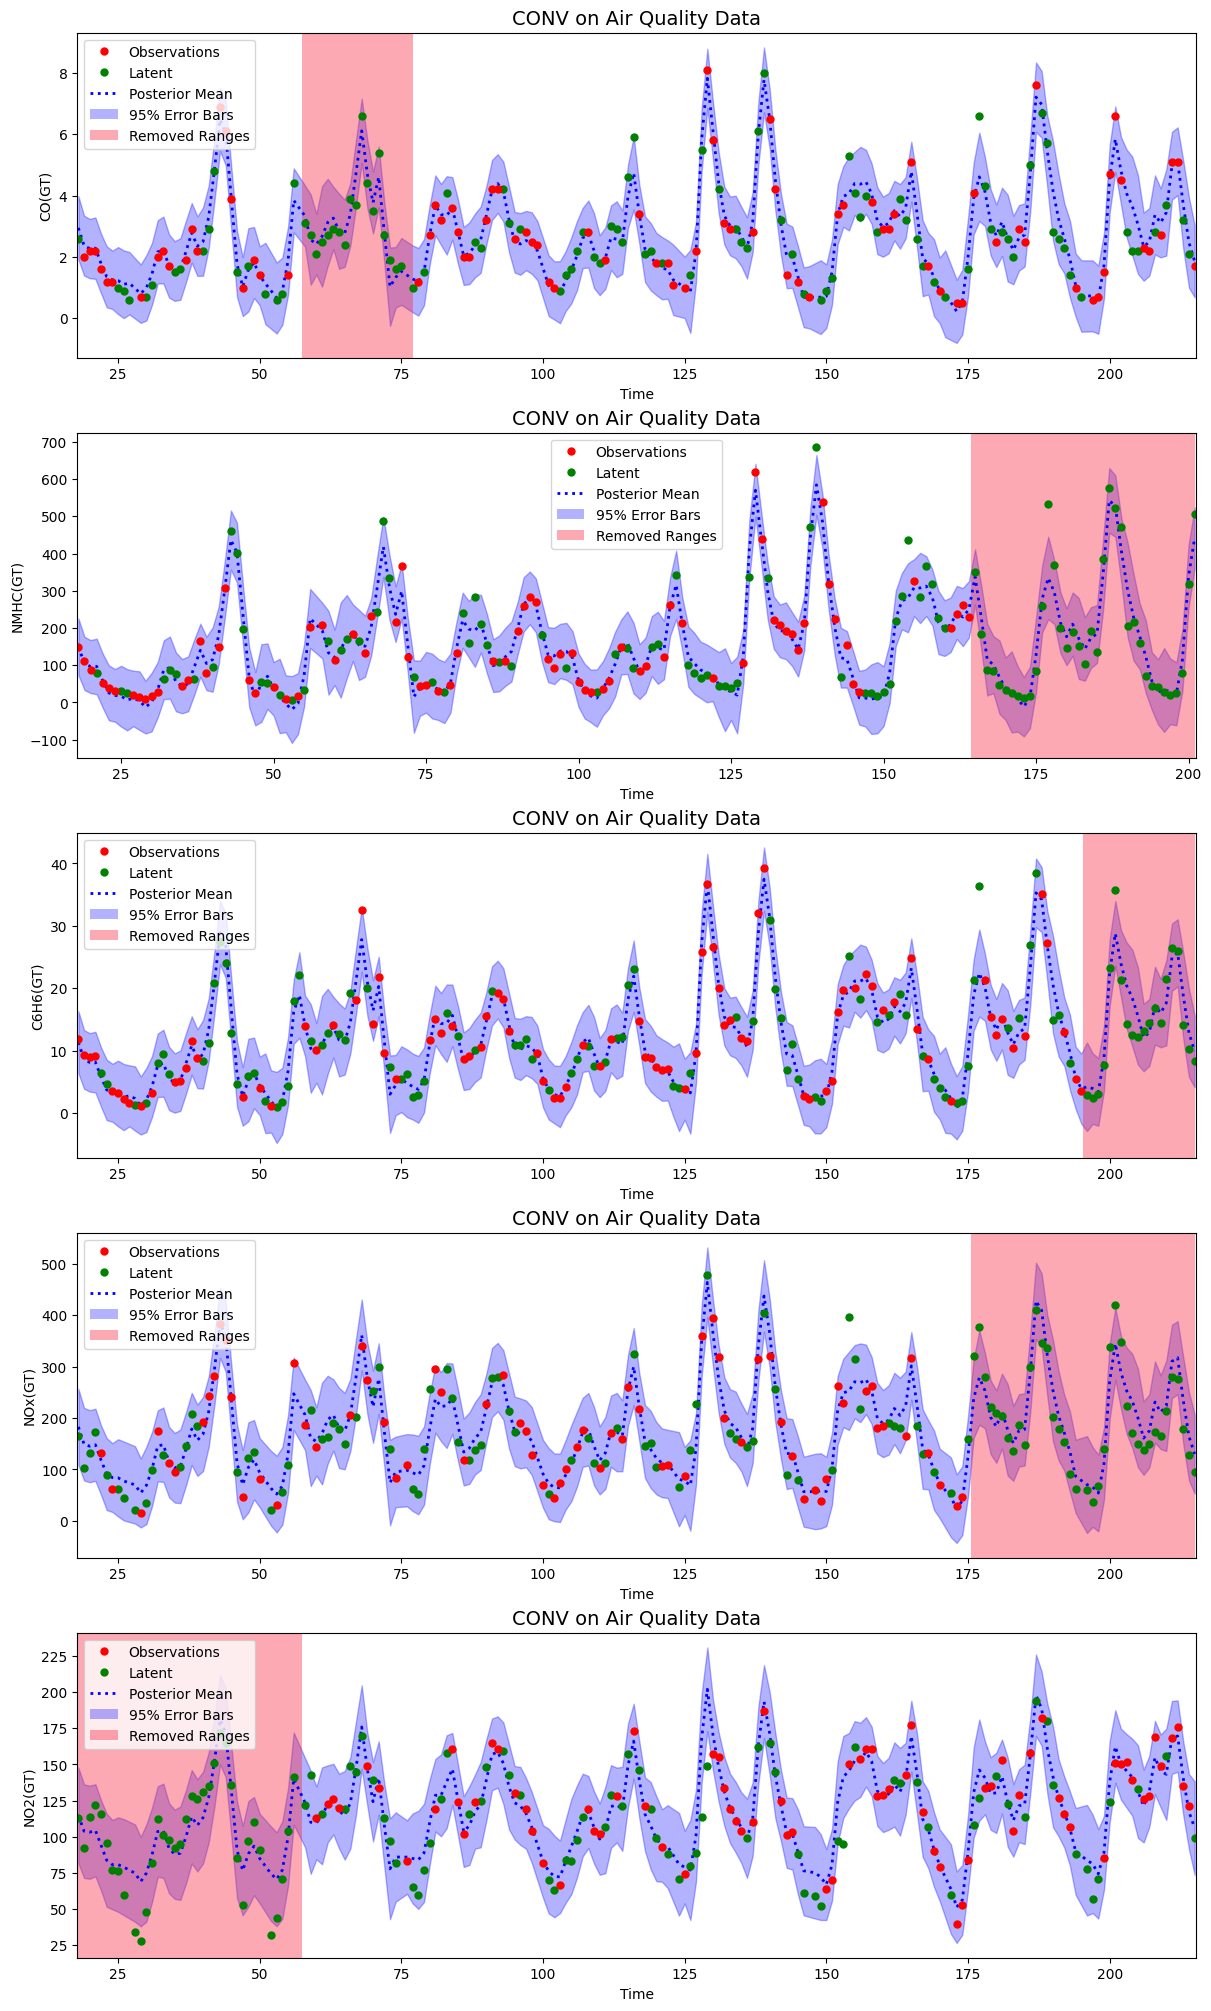

In [11]:
conv = mogptk.CONV(dataset, Q=4)
conv.init_parameters()
conv.train(method=method, lr=lr, iters=iters, verbose=True, error='MAE', plot=True)
conv.plot_prediction(title='CONV on Air Quality Data');

# Compare errors

We will take the mean MAE, MAPE, and RMSE for all the channels and compare all the models.

In [12]:
mogptk.error(sm, mosm, csm, smlmc, conv, disp=True)

MAE       MAPE       RMSE
Name                                   
SM      32.758392  51.100423  60.292392
MOSM    31.242253  47.680504  57.020081
CSM     26.946854  38.145051  52.273070
SM-LMC  27.068414  38.755937  51.631192
CONV    14.408723  19.680302  26.118271